<a href="https://colab.research.google.com/github/jenieto/computer-vision/blob/integrate-google-colab/computer-vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trabajo M0

In [0]:
# Montamos Google Drive
from google.colab import drive
drive.mount('/content/drive/')
!unzip -o "/content/drive/My Drive/Datasets/computer-vision-M2.zip" -d /content/

In [0]:
# Importamos librerias
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import os 
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split

In [0]:
# Definimos variables
csv_path = '/content/anotaciones_itemsEvaluables_v3.csv'
images_path = '/content/dataset1'
figure = 'a1'
image_shape = (512, 512, 1)
test_dataset_size = 0.25

In [0]:
# Funciones para leer los datos
def filter_figure(data, figure):
  filter = data['figure'] == figure
  return data[filter]
  
def read_csv_data(figure=None):
  data = pd.read_csv(csv_path, sep=';', names=['dir', 'image', 'figure', 'coords'], index_col=False, skipinitialspace=True)
  for key in data.keys():
    data[key] = data[key].apply(str.replace, args=(' ', ''))
  if figure is not None:
    data = filter_figure(data, figure)
  return data

In [129]:
# Leemos los datos
data = read_csv_data(figure)
data

,dir,image,figure,coords
5099,REY_roi_manualSelection1,ROI_0_Psic_119Ev5b.pdf_pg-28.jpg,a1,"(29,445)"
5100,REY_roi_manualSelection1,ROI_0_Psic_205Ev4.pdf_pg-70.jpg,a1,"(34,24)"
5101,REY_roi_manualSelection1,ROI_0_Psic_101Ev5.pdf_pg-27.jpg,a1,"(27,41)"
5102,REY_roi_manualSelection1,ROI_90_Psic_029Ev4.pdf_pg-24.jpg,a1,"(37,33)"
5103,REY_roi_manualSelection1,ROI_0_Psic_516Ev3.pdf_pg-26.jpg,a1,"(39,41)"
...,...,...,...,...
5418,REY_roi_manualSelection1,ROI_0_Psic_517Ev3.pdf_pg-26.jpg,a1,"(35,50)"
5419,REY_roi_manualSelection1,ROI_0_Psic_408Ev2.pdf_pg-35.jpg,a1,"(29,34)"
5420,REY_roi_manualSelection1,ROI_0_Psic_210Ev5.pdf_pg-54.jpg,a1,"(33,39)"
5421,REY_roi_manualSelection1,ROI_0_Psic_514Ev3.pdf_pg-20.jpg,a1,"(34,33)"


In [0]:
# Funcion para leer una imagen
def read_image(row):
  path = os.path.join(images_path, row['dir'], row['image'])
  image = cv2.imread(path,0)
  if image is not None: # TODO: algunas imagenes no existen
    image = cv2.resize(image, dsize=(image_shape[0], image_shape[1]))
    image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  return image

# Funcion para leer las coordenadas
def read_label(row, max_points = 1):
  coords_split = row['coords'].split('),(')
  coords_split = list(map(lambda x : x.replace('(','').replace(')',''), coords_split))
  row_coords = []
  if len(coords_split) > max_points: # TODO: Que hacemos con estos puntos?
    return None
  for coords in coords_split:
    numbers = coords.split(',')
    numbers = list(map(lambda x : int(x), numbers))
    row_coords.extend(numbers)
  return row_coords

# Funcion que devuelve las imagenes y las coordenadas
def read_images(data):
  images = []
  labels = []
  for index, row in data.iterrows():
    image = read_image(row)
    label = read_label(row)
    if image is not None and label is not None:
      images.append(image)
      labels.append(label)
  images = np.array(images)
  #images = images.reshape(images.shape[0], images.shape[1], images.shape[2], 1)
  return images, np.array(labels)

In [173]:
# Generamos las imagenes y los outputs
images, labels = read_images(data)
print(images.shape)
print(labels.shape)

(306, 512, 512)
(306, 2)


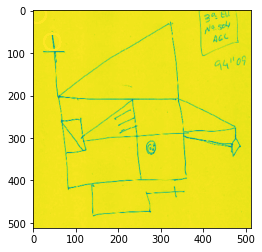

In [184]:
# Mostramos una imagen con el punto de la figura marcado
from matplotlib.pyplot import imshow, Normalize

def show_image(image, point=None):
  norm = Normalize(vmin=0., vmax=1., clip=True)
  if point is not None:
    image_with_circle = cv2.circle(image, (point[0], point[1]), 20, (255, 255, 0))
  imshow(image_with_circle, norm=norm)

show_image(images[50], labels[50])

In [0]:
# Creamos el modelo
def create_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=image_shape))
  model.add(tf.keras.layers.MaxPooling2D((2, 2)))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(2, activation='relu'))
  return model

# Creamos los datasets de train y test
def generate_datasets(images, labels):
  return train_test_split(images, labels, test_size=test_dataset_size)

In [0]:
model = create_model()
train_images, test_images, train_labels, test_labels = generate_datasets(images, labels)

In [127]:
# Compilamos y entrenamos el modelo
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history = model.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=10)

Epoch 1/10
8/8 [==============================] - 2s 206ms/step - loss: 9246.2246 - accuracy: 0.2402 - val_loss: 4029.8938 - val_accuracy: 0.2078
Epoch 2/10
8/8 [==============================] - 2s 195ms/step - loss: 7229.5532 - accuracy: 0.2402 - val_loss: 3973.1191 - val_accuracy: 0.2078
Epoch 3/10
8/8 [==============================] - 2s 194ms/step - loss: 6916.0562 - accuracy: 0.2402 - val_loss: 3975.8782 - val_accuracy: 0.2078
Epoch 4/10
8/8 [==============================] - 2s 194ms/step - loss: 6944.3330 - accuracy: 0.2402 - val_loss: 4017.9695 - val_accuracy: 0.2078
Epoch 5/10
8/8 [==============================] - 2s 197ms/step - loss: 10798.8750 - accuracy: 0.2402 - val_loss: 3971.2043 - val_accuracy: 0.2078
Epoch 6/10
8/8 [==============================] - 2s 194ms/step - loss: 6994.5298 - accuracy: 0.2402 - val_loss: 3992.2676 - val_accuracy: 0.2078
Epoch 7/10
8/8 [==============================] - 2s 196ms/step - loss: 6940.3735 - accuracy: 0.2402 - val_loss: 3971.3704 